# BASICS 03 - HOTS with online classification (Grimaldi et al. 2022)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../hots
import tonic, torch, os, pickle
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [3]:
type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset)
num_sample_train = len(loader)
num_sample_test = len(testset)
print(f'number of samples in the training set: {len(loader)}')

number of samples in the training set: 48


## Initialization of the network

In [4]:
name = 'homeohots'
homeo = True
timestr = '2022-04-27'
dataset_name = 'poker'

Rz = [2, 4]
N_neuronz = [8, 16]
tauz = [1e3, 4e3]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

initial_name = hots.name

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False)

initial_name_nohomeo = hots_nohomeo.name

device -> cuda
device -> cuda


## Unsupervised clustering

In [5]:
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold)
path_nohomeo = '../Records/networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering, filtering_threshold)

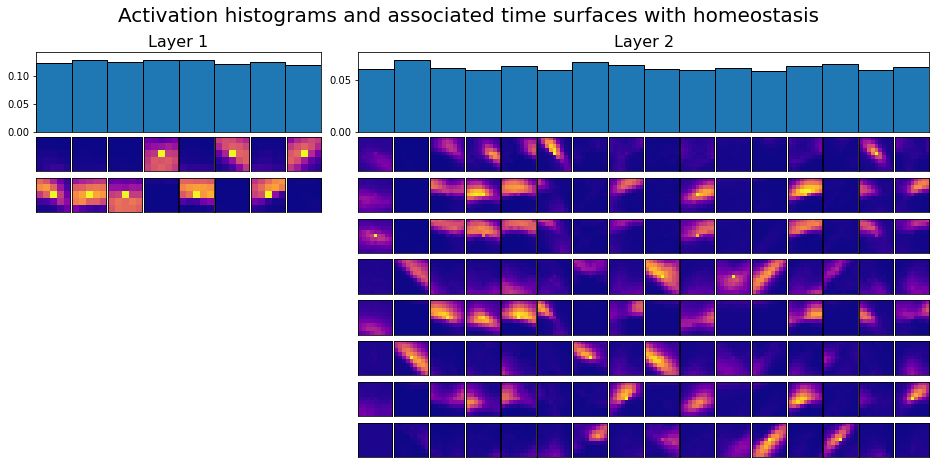

In [6]:
hots.plotlayers();

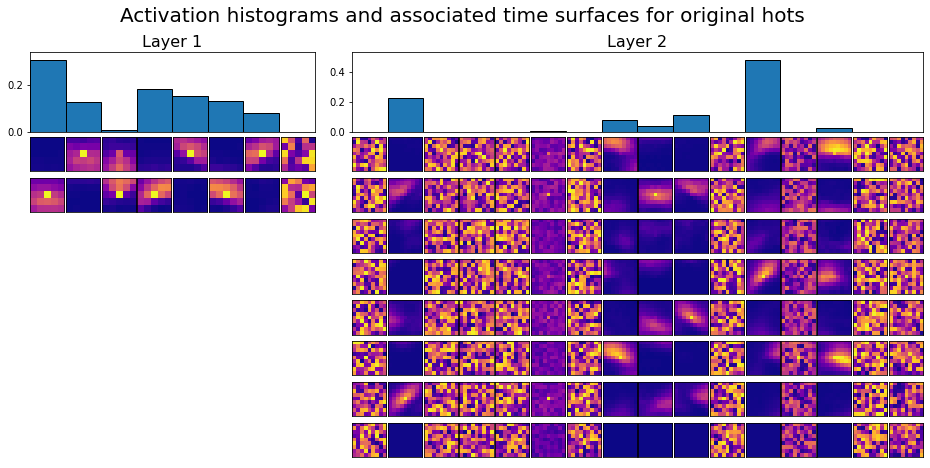

In [7]:
hots_nohomeo.plotlayers();

## Training of the classification layer

In [8]:
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 2e4

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
trainloader = get_loader(trainset_output)
classif_layer, losses = fit_mlr(trainloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))


hots_nohomeo.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=True)

train_path_nohomeo = f'../Records/output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
model_path_nohomeo = f'../Records/networks/{hots_nohomeo.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
trainloader_nohomeo = get_loader(trainset_output_nohomeo)
classif_layer_nohomeo, losses_nohomeo = fit_mlr(trainloader_nohomeo, model_path_nohomeo, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-27_poker_homeohots_False_[8, 16]_[1000.0, 4000.0]_[2, 4]_48_(None, None)/


In [9]:
import numpy as np
from tqdm import tqdm

if not os.path.exists('../Records/jitter_results/'):
    os.mkdir('../Records/jitter_results/')

nb_trials = 10
n_classes = len(testset.classes)

std_jit_s = np.linspace(0,10,20)
var_jit_s = std_jit_s**2
scores_jit_s = np.zeros([nb_trials, len(var_jit_s)])
scores_jit_s_histo = np.zeros([nb_trials, len(var_jit_s)])
scores_jit_s_histo_nohomeo = np.zeros([nb_trials, len(var_jit_s)])

torch.set_default_tensor_type("torch.DoubleTensor")

for trial in tqdm(range(nb_trials)):
    for ind_jit, spatial_jitter in enumerate(var_jit_s):
        if spatial_jitter==0:
            jitter = (None,None)
        else:
            jitter = (spatial_jitter,None)
        test_path = f'../Records/output/test/{initial_name}_{trial}_{num_sample_test}_{jitter}/'
        results_path = f'../Records/LR_results/{initial_name}_{trial}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
        hots.name = initial_name+f'_{trial}'
        
        spatial_jitter_transform = tonic.transforms.SpatialJitter(sensor_size = trainset.sensor_size, variance_x = spatial_jitter, variance_y = spatial_jitter, clip_outliers = True)
        spatial_jitter_transform_full = tonic.transforms.Compose([spatial_jitter_transform, type_transform])
        testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=spatial_jitter_transform_full)
        loader = get_loader(testset)
        hots.coding(loader, testset.ordering, testset.classes, filtering_threshold, training=False, jitter = jitter, verbose=False)
        
        testset_output = HOTS_Dataset(test_path, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
        testloader = get_loader(testset_output)
        
        likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,testloader,results_path,ts_size,testset_output.ordering)
        meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, verbose=False)
        
        scores_jit_s_histo[trial,ind_jit] = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
        scores_jit_s[trial,ind_jit] = lastac
        
        
        test_path_nohomeo = f'../Records/output/test/{initial_name_nohomeo}_{trial}_{num_sample_test}_{jitter}/'
        results_path_nohomeo = f'../Records/LR_results/{initial_name_nohomeo}_{trial}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
        hots_nohomeo.name = initial_name_nohomeo+f'_{trial}'
        
        hots_nohomeo.coding(loader, testset.ordering, testset.classes, filtering_threshold, training=False, jitter=jitter, verbose=False)
        testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
        
        scores_jit_s_histo_nohomeo[trial,ind_jit] = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_neuronz[-1])
        
        #print(f'For jitter variance {spatial_jitter} pixels, accuracy is {lastac*100}%')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.78s/it]


In [25]:
std_jit_t = np.logspace(0,5,20)
print(std_jit_t)

[1.00000000e+00 1.83298071e+00 3.35981829e+00 6.15848211e+00
 1.12883789e+01 2.06913808e+01 3.79269019e+01 6.95192796e+01
 1.27427499e+02 2.33572147e+02 4.28133240e+02 7.84759970e+02
 1.43844989e+03 2.63665090e+03 4.83293024e+03 8.85866790e+03
 1.62377674e+04 2.97635144e+04 5.45559478e+04 1.00000000e+05]


In [10]:
std_jit_t = np.logspace(0,5,20)
scores_jit_t = np.zeros([nb_trials, len(std_jit_t)])
scores_jit_t_histo = np.zeros([nb_trials, len(std_jit_t)])
scores_jit_t_histo_nohomeo = np.zeros([nb_trials, len(std_jit_t)])

torch.set_default_tensor_type("torch.DoubleTensor")

for trial in tqdm(range(nb_trials)):
    for ind_jit, temporal_jitter in enumerate(std_jit_t):
        if temporal_jitter==0:
            jitter = (None,None)
        else:
            jitter = (None,temporal_jitter)
        test_path = f'../Records/output/test/{initial_name}_{trial}_{num_sample_test}_{jitter}/'
        results_path = f'../Records/LR_results/{initial_name}_{trial}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
        hots.name = initial_name+f'_{trial}'
        
        tonic.transforms.TimeJitter(std = temporal_jitter, clip_negative = True, sort_timestamps = True)
        temporal_jitter_transform = tonic.transforms.TimeJitter(std = temporal_jitter, clip_negative = True, sort_timestamps = True)
        temporal_jitter_transform_full = tonic.transforms.Compose([temporal_jitter_transform, type_transform])
        testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=temporal_jitter_transform_full)
        loader = get_loader(testset)
        hots.coding(loader, testset.ordering, testset.classes, filtering_threshold, training=False, jitter = jitter, verbose=False)
        
        testset_output = HOTS_Dataset(test_path, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
        testloader = get_loader(testset_output)
        
        likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,testloader,results_path,ts_size,testset_output.ordering)
        meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, verbose=False)
        
        scores_jit_t_histo[trial,ind_jit] = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
        scores_jit_t[trial,ind_jit] = lastac
        
        test_path_nohomeo = f'../Records/output/test/{initial_name_nohomeo}_{trial}_{num_sample_test}_{jitter}/'
        results_path_nohomeo = f'../Records/LR_results/{initial_name_nohomeo}_{trial}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
        hots_nohomeo.name = initial_name_nohomeo+f'_{trial}'
        
        hots_nohomeo.coding(loader, testset.ordering, testset.classes, filtering_threshold, training=False, jitter=jitter, verbose=False)
        testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
        
        scores_jit_t_histo_nohomeo[trial,ind_jit] = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_neuronz[-1])
        #print(f'For jitter standard deviation {temporal_jitter} microsec, accuracy is {lastac*100}%')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.01s/it]


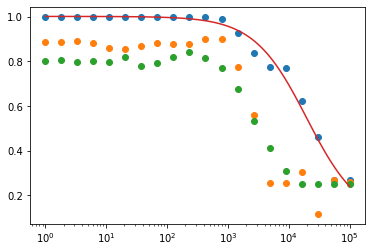

In [88]:
import matplotlib.pyplot as plt
plt.semilogx(np.hstack([np.array([0]),std_jit_t]), np.hstack([np.array([1]),scores_jit_t.mean(axis=0)]), 'o')
plt.semilogx(np.hstack([np.array([0]),std_jit_t]), np.hstack([np.array([1]),scores_jit_t_histo.mean(axis=0)]), 'o')
plt.semilogx(np.hstack([np.array([0]),std_jit_t]), np.hstack([np.array([1]),scores_jit_t_histo_nohomeo.mean(axis=0)]), 'o')
plt.semilogx(contrast_cont, nr_fit)

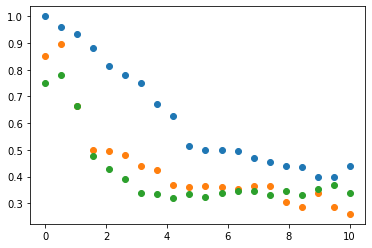

In [89]:
plt.plot(std_jit_s, scores_jit_s.mean(axis=0), 'o')
plt.plot(std_jit_s, scores_jit_s_histo.mean(axis=0), 'o')
plt.plot(std_jit_s, scores_jit_s_histo_nohomeo.mean(axis=0), 'o')

In [144]:
from scipy.stats import beta
from scipy.optimize import curve_fit
def plotjitter(fig, ax, jit, score, param = [0.8, 22, 4, 0.1], color='red', label='name', nb_class=10, n_epo = 33, fitting = True, logscale = False):
    score_stat = np.zeros([3,len(jit)])
    q = [0.05,0.95]
    for i in range(score.shape[1]):
        mean = np.mean(score[:,i])
        if np.unique(score[:,i]).shape[0]==1:
            score_stat[0,i], score_stat[1,i], score_stat[2,i] = mean, mean, mean
        else:
            var = np.std(score[:,i])
            #alpha=mean**2*(1-mean)/var-mean
            #alpha = max(alpha,1e-2)
            #be=alpha*(1-mean)/mean
            paramz = beta.fit(score[:,i]*.9999+.00001, floc=0, fscale = 1)
            score_stat[0,i], score_stat[2,i] = beta.ppf(q, a=paramz[0], b=paramz[1])
            score_stat[1,i] = np.mean(score[:,i])

    if fitting:
        Rmin,Rmax,semisat = fit_NR(jit,score_stat[1,:])
        if logscale:
            jitter_cont = np.logspace(np.min(np.log10(jit)),np.max(np.log10(jit)),100) 
            nr_fit = NR_jitter(jitter_cont,Rmin,Rmax,semisat)
            ax.semilogx(jitter_cont, nr_fit*100, color=color, lw=1)
        else:
            jitter_cont = np.linspace(np.min(jit),np.max(jit),100) 
            nr_fit = NR_jitter(jitter_cont,Rmin,Rmax,semisat)
            ax.plot(jitter_cont, nr_fit*100, color=color, lw=1)
    if logscale:
        ax.semilogx(jit, score_stat[1,:]*100, '.',color=color, label=label)
    else:
        ax.plot(jit, score_stat[1,:]*100, '.',color=color, label=label)
    ax.fill_between(jit, score_stat[2,:]*100, score_stat[0,:]*100, facecolor=color, edgecolor=None, alpha=.3)
        
    x = []
    if fitting:
        # semi-saturation levels
        chance = 1/nb_class
        valmax = score_stat[1,0]
        semisat = (valmax-chance)/2
        y = 1
        x = 0
        while y>semisat:
            x += 0.01
            y = NR_jitter(x,Rmin,Rmax,semisat)

    return fig, ax, x

In [145]:
def NR_jitter(x,Rmax,Rmin,semisat): 
    r = Rmax-Rmax*x/(x+semisat)+Rmin
    return r 

def fit_NR(jitter,accuracy,init_params=[0,1,1e4],lower_bounds=[0,0,10],upper_bounds=[1,1,1e5]):
       
    popt, pcov = curve_fit(NR_jitter, jitter, accuracy, p0 = init_params, bounds = (lower_bounds,upper_bounds))
    
    Rmin = popt[0]
    Rmax = popt[1]
    semisat = popt[2]

    return Rmin,Rmax,semisat

In [146]:
colorz = ['#2ca02c','#1f77b4','#d62728']

fitting = True
logscale = True

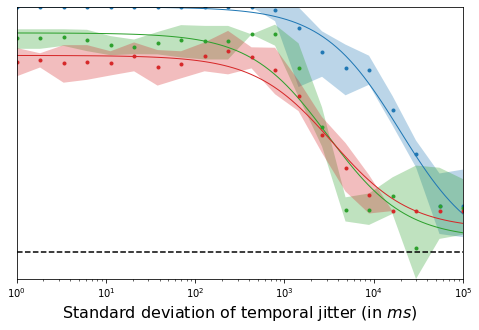

In [149]:
fig_t, ax_t = plt.subplots(1,1,figsize=(8,5))
param_T = [0.85, 2.5, 5, 0.1]
label = 'online HOTS (ours)'
n_epoch = 33
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, std_jit_t, scores_jit_t, param = param_T, color=colorz[1], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
    
label = 'HOTS with homeostasis'
param_T = [0.8, 1.7, 5, 0.1]
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, std_jit_t, scores_jit_t_histo, param = param_T, color=colorz[0], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)

label = 'original HOTS'
param_T = [0.8, 1.3, 5, 0.1]
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, std_jit_t, scores_jit_t_histo_nohomeo, param = param_T, color=colorz[2], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)

chance_t = np.ones([len(std_jit_t)])*10
ax_t.plot(std_jit_t,chance_t, 'k--', label='chance level')
ax_t.axis([1,max(std_jit_t),0,100]);
ax_t.set_xlabel('Standard deviation of temporal jitter (in $ms$)', fontsize=16);
#ax_t.set_ylabel('accuracy (in %)', fontsize=16);
ax_t.set_yticks([]);
#ax_t.set_title('Accuracy as a function of temporal jitter', fontsize=16);
#ax_t.legend(fontsize=12);

In [ ]:
fig_s, ax_s = plt.subplots(1,1,figsize=(8,5))
param_S = [0.85, 2.5, 3, 0.1]
label = 'online HOTS (ours)'
n_epoch = 33
fig_s, ax_s, semisat_s = plotjitter(fig_s, ax_s, std_jit_s, scores_jit_s, param = param_S, color=colorz[1], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_s,2)} pixels')

label = 'HOTS with homeostasis'
param_S = [0.85, 2, 3, 0.1]
fig_s, ax_s, semisat_s = plotjitter(fig_s, ax_s, std_jit_s, scores_jit_s_histo, param = param_S, color=colorz[0], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_s,2)} pixels')

label = 'original HOTS'
param_S = [0.8, 1, 2.5, 0.1]
fig_s, ax_s, semisat_s = plotjitter(fig_s, ax_s, std_jit_s, scores_jit_s_histo_nohomeo, param = param_S, color=colorz[2], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_s,2)} pixels')

chance_s = np.ones([len(std_jit_s)])*10
ax_s.plot(std_jit_s,chance_s, 'k--', label='chance level')
ax_s.axis([0,max(std_jit_s),0,100]);
ax_s.set_xlabel('Standard deviation of spatial jitter (in pixel)', fontsize=16);
ax_s.set_ylabel('Accuracy (in %)', fontsize=16);
#ax_s.set_title('Accuracy as a function of spatial jitter', fontsize=16);
#plt.yticks([],[])
#ax_s.set_yticks([])
ax_s.legend(fontsize=12);